# How do acoustic features of songs influence their rank? 

Authors: Yashas Lokesh, Renee Yang, Kavya Dagli

Musicologist Dr. Alison Pawley and psychologist Dr. Daniel Mullensiefen out at the University of London claim that it is possible to identify if a song will be popular. Two of the attributes that they predict make songs popular are "longer and detailed musical phrases" and "a higher number of pitches." We will put this claim to the test by analyzing the relationship between song audio features and song rank. We will also explore if there are additional features that influence popularity. 

![](billboard_img.jpg)

# 1. Getting Started

## 1.1 Required Libraries 

In [1]:
import pandas as pd
import sqlite3
import sqlalchemy as db
import seaborn as scs
import matplotlib.pyplot as plt
import numpy as np

## 1.2 Dataset Source

The dataset we use is scraped comes from two different sources. The first source is the Billboard Top 100 data over 100 years. This dataset includes the rank of albums overtime. 

This data can be accessed here: LINK

The second source comes from AllMusic. This dataset includes songs in albums and various audio features of each song such as instrumentalness, energy, and valence. 

This data can be accessed here: LINK


## 1.3 Load and View Data 

In [2]:
engine = db.create_engine('sqlite:///billboard-200 2.db')
conn = engine.connect()

In [3]:
acoustic_features = pd.read_sql_table('acoustic_features', conn)
acoustic_features.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


In [4]:
acoustic_features.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,339850.000000,339850.000000,3.398500e+05,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000,339850.000000
mean,0.298806,0.541176,2.367351e+05,0.616716,0.098277,5.239526,0.233439,-9.072759,0.705700,0.092625,119.933974,3.887547,0.506169
std,0.315533,0.170821,1.022557e+05,0.244043,0.241980,3.553370,0.215256,4.601032,0.455728,0.128894,30.380899,0.453673,0.253193
min,0.000000,0.000000,1.062000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021500,0.425000,1.865218e+05,0.440000,0.000000,2.000000,0.098200,-11.575000,0.000000,0.033400,96.188250,4.000000,0.302000
50%,0.164000,0.547000,2.263730e+05,0.647000,0.000053,5.000000,0.141000,-8.121000,1.000000,0.044700,118.223000,4.000000,0.506000
75%,0.546000,0.664000,2.710000e+05,0.822000,0.011100,8.000000,0.299000,-5.679000,1.000000,0.084000,139.288000,4.000000,0.712000
max,0.996000,0.988000,4.734079e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.968000,247.824000,5.000000,1.000000


In [19]:
albums = pd.read_sql_table('albums', conn)
albums.head()

,id,date,artist,album,rank,length,track_length
0,1,None,None,None,None,NaN,NaN
1,2,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1,20.0,185233.800000
2,3,2019-01-19,21 Savage,I Am > I Was,2,15.0,211050.733333
3,4,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3,13.0,190866.384615
4,5,2019-01-19,Meek Mill,Championships,4,19.0,219173.894737


In [6]:
albums.describe()

,id,length,track_length
count,573947.000000,492547.000000,4.688670e+05
mean,286974.000000,13.728933,2.443541e+05
std,165684.371813,7.960640,7.195498e+04
min,1.000000,1.000000,2.542290e+04
25%,143487.500000,10.000000,2.100814e+05
50%,286974.000000,12.000000,2.372190e+05
75%,430460.500000,15.000000,2.680566e+05
max,573947.000000,666.000000,4.457023e+06


## 1.4 Cleaning and Modifying Data 

After viewing the data, it is apparent that many of the features contain null values. We decided to drop these values to prevent complications with performing operations on the two dataframes later on. 

In [7]:
acoutstic_features = acoustic_features.dropna()
albums = albums.dropna()

We combined the two dataframes here so that the rank of each album could be accessed from the ACOUSTIC_FEATURES dataframe. We decided to extract the best rank for an album from the ALBUMS dataframe and place it in the 'rank' column of ACOUSTIC_FEATURES. We will start by creating a dictionary that maps the album to its best rank.

In [39]:
def highest_rank(df, album):
    target = df[df.album == album]
    return target['rank'].min()

ranks = {}
for a in albums["album"].unique():
    ranks[a] = highest_rank(albums, a)

Now that we have mapped albums to their best rank, we will create the 'rank' column in ACOUSTIC_FEATURES. We noticed that some albums in ACOUSTIC_FEATURES do not appear in ALBUMS so we could not get a best rank for them. In this case we set that album's rank as NaN and dropped the row. 

In [41]:
col = []
for index, row in acoustic_features.iterrows():
    try:
        col.append(int(ranks[row['album']]))
    except:
        col.append(np.nan)
acoustic_features['rank'] = col

Finally, we have a table containing all song's acoustic features and their album's corresponding rank!

In [42]:
acoustic_features = acoustic_features.dropna()
acoustic_features.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21,1


# 2. Exploring Popular Songs 

## 2.1 Audio Features of Top Songs 

Now that we have modified our ACOUSTIC_FEATURES dataset to our linking, let's start by exploring the top songs in the dataset. Top songs are those that belong to albums with a number one ranking, as indicated by the 'rank' column. We will first isolate the top songs into their own dataframe. 

In [59]:
top_songs = acoustic_features[acoustic_features['rank'] == 1]
len(top_songs)

13702

We are able to find 13702 top songs in our table! Here are a few #1 hits:

In [167]:
top_songs.sample(n=5)

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
21386,2Wl2S9Fmjg2GFCu8qtwyi0,Playa Hater - 2014 Remaster,Life After Death,The Notorious B.I.G.,0.0538,0.501,237933.0,0.717,0.000000,4.0,0.1210,-6.811,0.0,0.0334,127.194,4.0,0.253,7dRdaGSxgcBdJnrOviQRuB,1997-03-04,1
13910,3tqwKg0W8XfYORNrP4aIhu,Hey Hey Hey,Witness,Katy Perry,0.0516,0.652,214960.0,0.703,0.000000,9.0,0.0521,-5.632,1.0,0.0994,134.066,4.0,0.485,0UlbGi4oAth8s6rwaGSU8Z,2017-06-09,1
291114,33k3NhmG44wANgfRok7BlA,Leaving This Town - Live/Remastered 2000,Beach Boys In Concert,The Beach Boys,0.3090,0.452,419677.0,0.677,0.000453,2.0,0.1300,-8.085,1.0,0.0403,126.830,4.0,0.412,5L5IfzUWYGXQxiDvzLEUme,1973-11-19,1
24945,6QFgpUiLoXlmYDjbe0tjyP,Start Over,4,Beyonce,0.1930,0.474,199107.0,0.797,0.000006,6.0,0.3220,-4.541,0.0,0.1910,150.006,4.0,0.398,1gIC63gC3B7o7FfpPACZQJ,2011,1
58933,0un5QdMnuibGplkMHYorvg,Dream Baby Dream,High Hopes,Bruce Springsteen,0.1210,0.462,302253.0,0.478,0.000000,7.0,0.0655,-8.160,1.0,0.0316,109.948,4.0,0.183,6QH6ltpFEZXObrQHmgpKSN,2014-01-14,1


Now we will average each audio feature to get an idea of the audio features for popular songs.

In [137]:
top_song_avg = top_songs.loc[:,'acousticness':'valence'].mean()
top_song_avg = top_song_avg.sort_values()
top_song_avg

loudness                -8.208204
instrumentalness         0.063362
speechiness              0.104245
liveness                 0.211205
acousticness             0.264563
valence                  0.498550
danceability             0.568800
energy                   0.630867
mode                     0.677565
time_signature           3.908189
key                      5.262735
tempo                  119.226241
duration_ms         237372.932929
dtype: float64

We are dropping some of the very large and very small values for the purpose of graphing, but don't worry we'll include them in our analysis.

In [138]:
top_song_avg = top_song_avg.drop(labels=['duration_ms', 'tempo', 'loudness'])

Here is a plot of the average features of #1 ranked songs:

In [139]:
plt.style.use('seaborn-pastel')

HOW TO SET TITLE?!?!?!?! :')

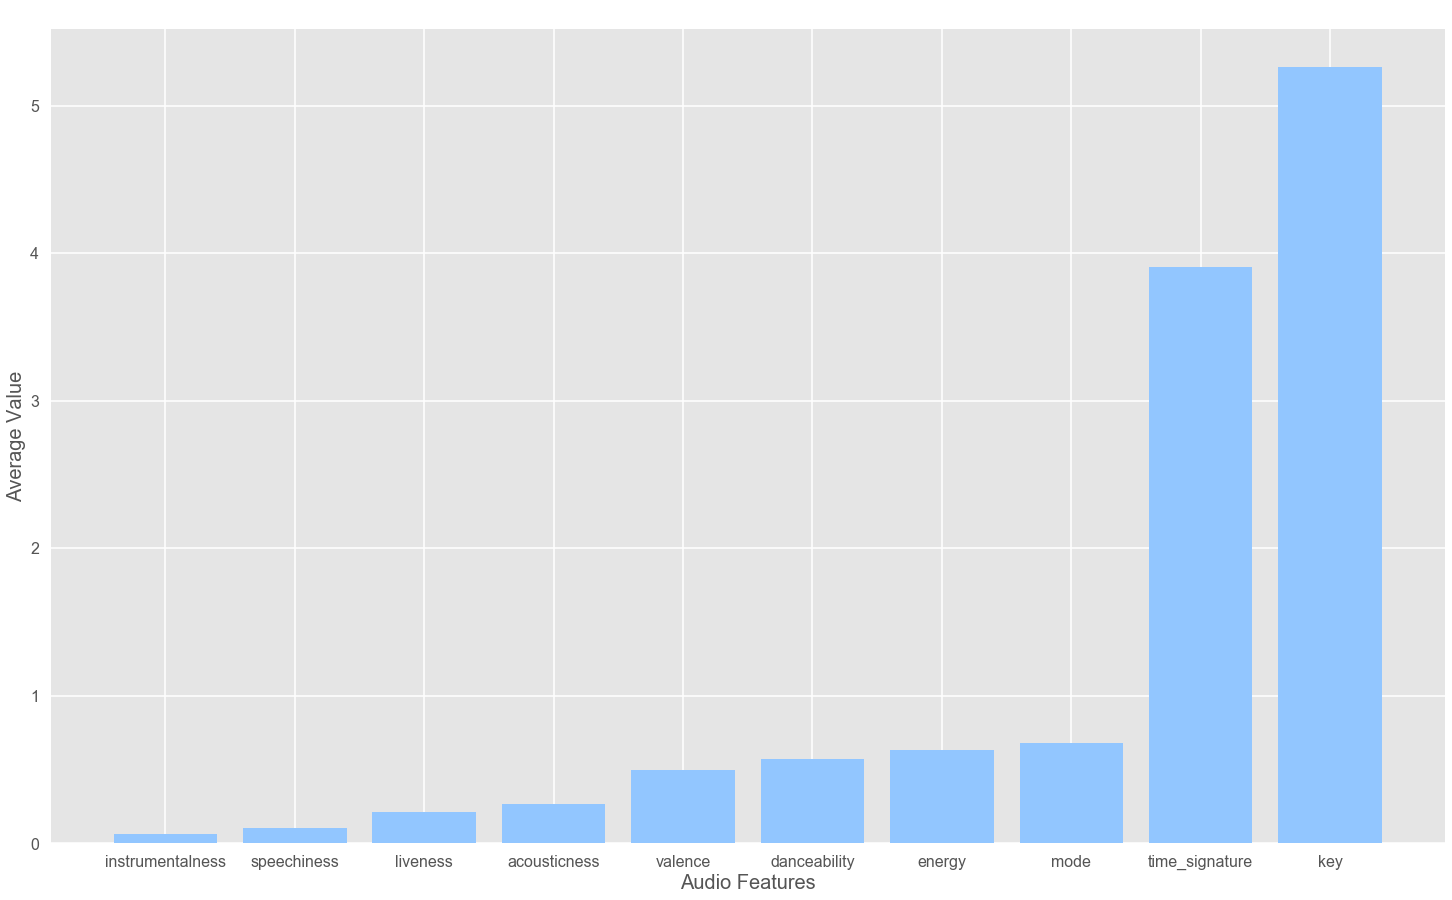

In [177]:
plt.figure(figsize=(25,15))
plt.title("Avereage Audio Features of Top Songs", fontsize=20)
plt.xlabel("Audio Features", fontsize=20)
plt.ylabel("Average Value", fontsize=20)
plt.bar(top_song_avg.keys(),top_song_avg)
plt.show()

## 2.2 Popular Songs vs. Low Ranked Songs 

In order to compare the audio features of low-ranked songs to high-ranked songs, let's first look at the lowest rank in our table. We can do this by getting the value counts of the data in the 'rank' column. 

In [160]:
acoustic_features['rank'].value_counts().sort_index()

1      13702
3         16
4         11
5         22
6         15
       ...  
196      897
197      887
198      934
199      710
200      818
Name: rank, Length: 199, dtype: int64

Now we know that the lowest rank a song can achieve is 200. Getting the count of each rank has also indicated that we have a sizeable sample to calculate an average from! (818 songs to be exact)

In [163]:
low_ranked = acoustic_features[acoustic_features['rank'] == 200]
low_ranked.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date,rank
9514,6PY0zFbmh6TWMQDDnJqKmi,Just A Fool,Uniform Distortion,Jim James,0.4190,0.485,240040.0,0.723,0.045900,4.0,0.1510,-6.729,1.0,0.0438,118.143,4.0,0.515,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200
9515,0Evixriu8Jdn5vkXXTTCqV,You Get To Rome,Uniform Distortion,Jim James,0.1080,0.400,148200.0,0.892,0.000000,11.0,0.3060,-4.427,0.0,0.0899,129.838,4.0,0.382,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200
9516,1kEhCIq9sfLADamf4Tm5jT,Out Of Time,Uniform Distortion,Jim James,0.0442,0.221,171760.0,0.818,0.001750,2.0,0.2280,-5.788,1.0,0.0864,102.079,4.0,0.261,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200
9517,7FWL3U5cjcbLZxLzBKJbXC,Throwback,Uniform Distortion,Jim James,0.0224,0.402,318800.0,0.864,0.000007,6.0,0.0777,-5.316,1.0,0.0481,117.281,4.0,0.487,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200
9518,2v96SpFC6LS53llretL3kN,No Secrets,Uniform Distortion,Jim James,0.3260,0.452,292533.0,0.673,0.000126,11.0,0.0986,-6.037,1.0,0.0329,112.050,4.0,0.290,7bDsFXWrq3zXuyQlIzJU6j,2018-06-29,200


In [168]:
low_ranked_avg = low_ranked.loc[:,'acousticness':'valence'].mean()
low_ranked_avg = low_ranked_avg.sort_values()
low_ranked_avg

loudness                -7.953296
speechiness              0.080588
instrumentalness         0.124114
liveness                 0.236841
acousticness             0.256166
valence                  0.505243
danceability             0.523214
energy                   0.667529
mode                     0.710269
time_signature           3.882641
key                      5.496333
tempo                  121.067622
duration_ms         241467.528117
dtype: float64

Again dropping very low and very high values...

In [169]:
low_ranked_avg = low_ranked_avg.drop(labels=['duration_ms', 'tempo', 'loudness'])

Since we have the average data for the lowest and highest ranked songs we can graph them side-by-side and see if the value differ

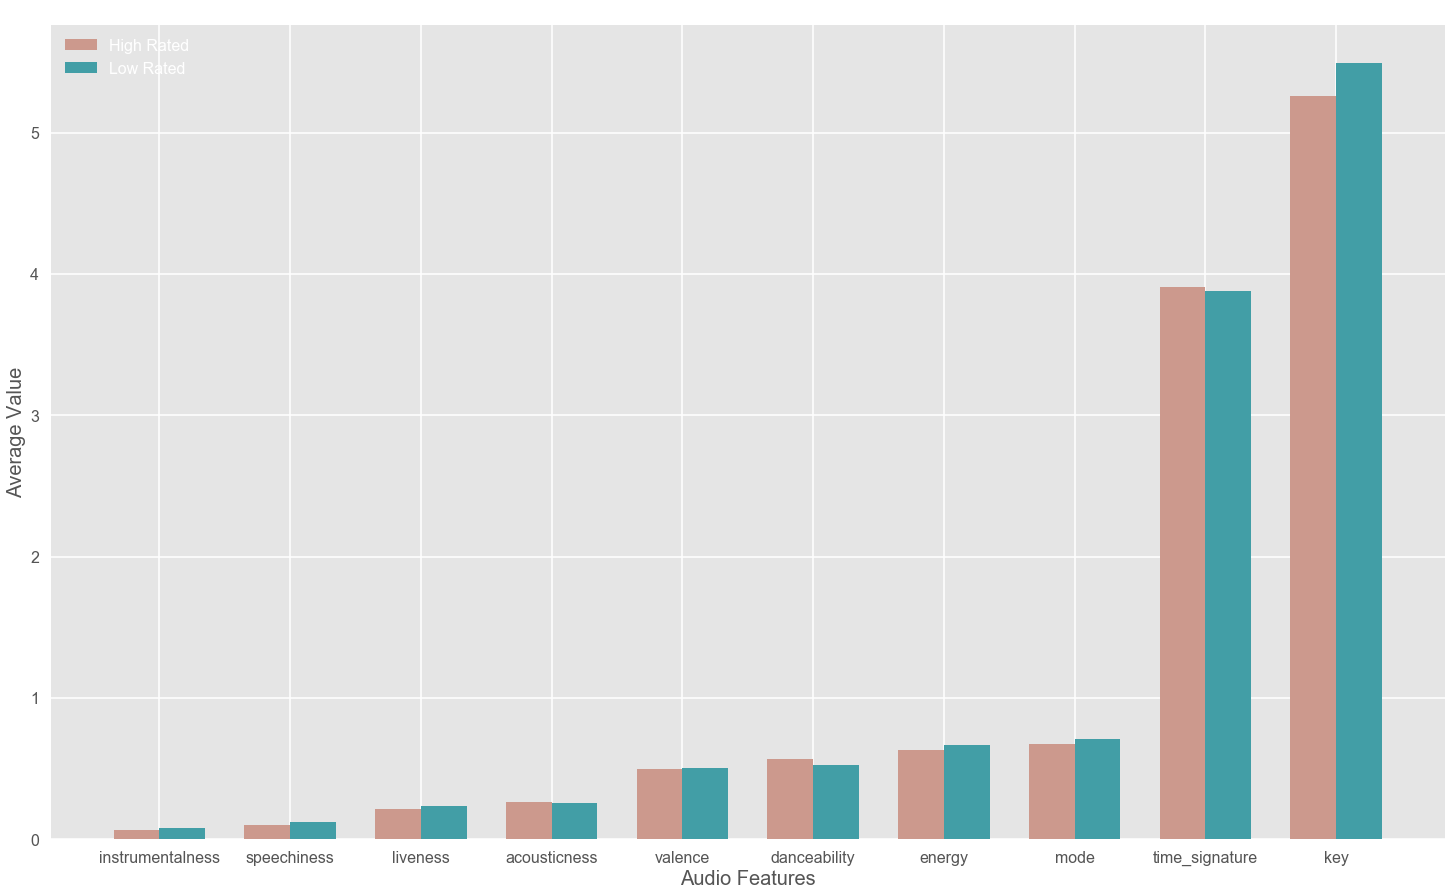

In [185]:
ind = np.arange(len(low_ranked_avg))  
width = 0.35       

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
avgs1 = ax.bar(ind, top_song_avg, width, color='#CC998D')

womenMeans = (25, 32, 34, 20, 25)
womenStd =   (3, 5, 2, 3, 3)
avgs2 = ax.bar(ind+width, low_ranked_avg, width, color='#429EA6')

ax.set_ylabel('Average Value', fontsize=20)
ax.set_xlabel('Audio Features', fontsize=20)
ax.set_title('Average Audio Features of High and Low Ranked Songs')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(top_song_avg.keys())
ax.legend( (avgs1[0], avgs2[0]), ('High Rated', 'Low Rated') )
plt.show()

**Observations**

- There are no drastic differences between features of low and high rated songs
- 'key' is higher for low-rated songs
- high-rated songs are slightly longer 
- all other features are higher in value for low-rated songs, exept for danceability 

A bar graph of the difference in each feature will better demonstrate the change in average feature value between low and high rated songs. 

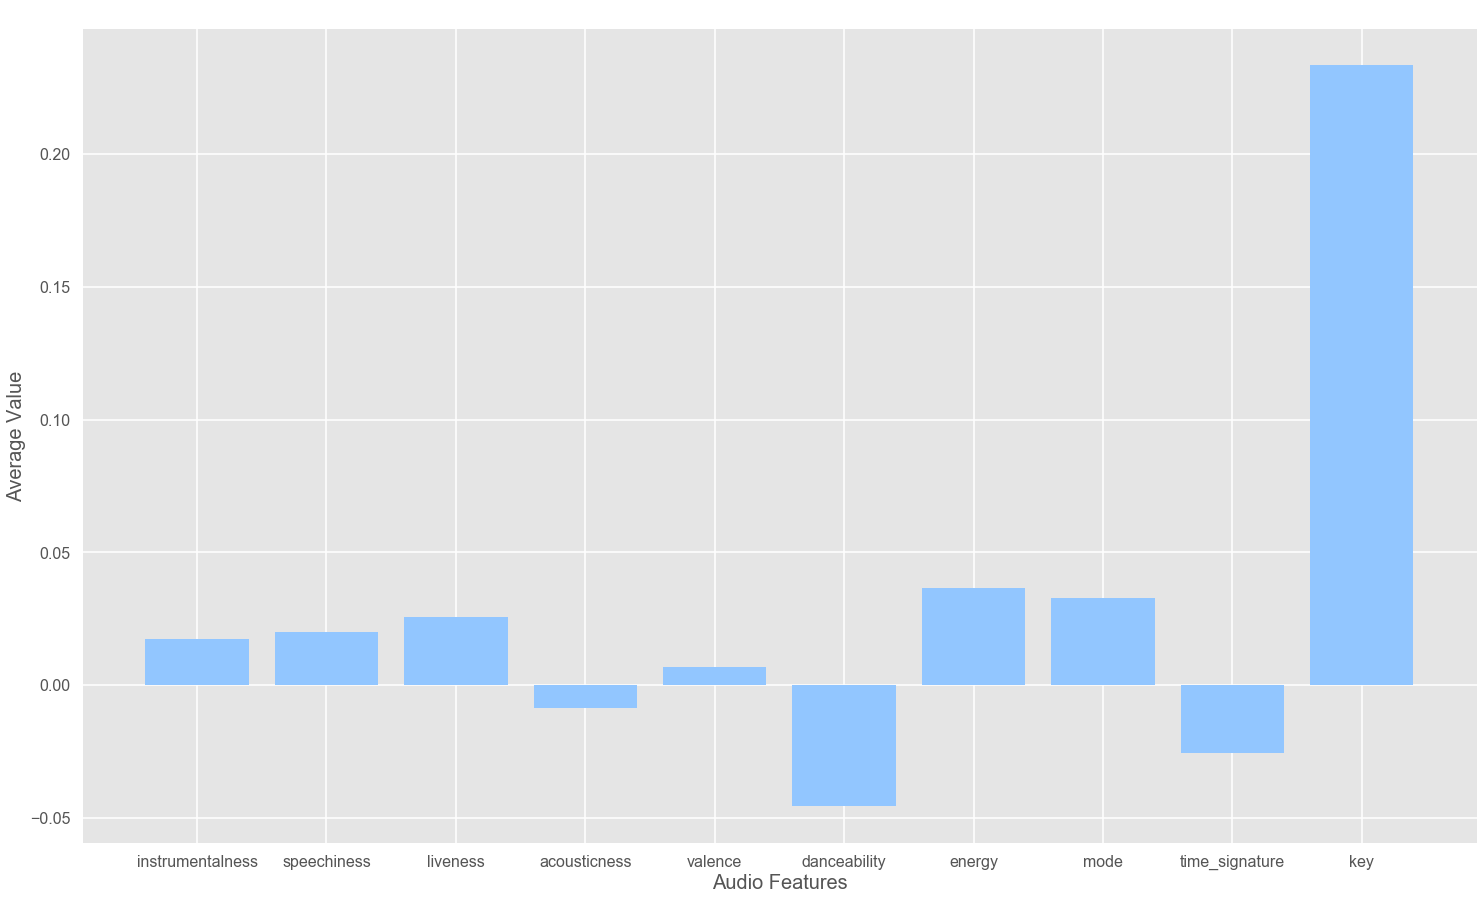

In [189]:
diffs = [a - b for a, b in zip(low_ranked_avg, top_song_avg)]

plt.figure(figsize=(25,15))
plt.title("Avereage Audio Features of Top Songs", fontsize=20)
plt.xlabel("Audio Features", fontsize=20)
plt.ylabel("Average Value", fontsize=20)
plt.bar(top_song_avg.keys(),diffs)
plt.show()

**Observations**

- The highest difference between averages is for 'key'
- The second highest difference is for 'dancibility'
- All other differences seem to be less than or around 0.25

This may indicate that key and dancibility are highly influenctial in determining a song's rank. To evaluate this, we will determine the correlation of these factors in our analysis section.

In [ ]:
year_slices = ['196', '197', '198', '199', '200', '201']

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='acousticness',
                y='danceability',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='energy',
                y='danceability',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='instrumentalness',
                y='speechiness',
                hue='album',
                legend=False,
                data=sliced_df)

In [ ]:
for s in year_slices:
    plt.figure()
    
    sliced_df = df.loc[df.date.apply(lambda x: x[:3] == s)]
    
    scs.scatterplot(x='energy',
                y='tempo',
                hue='album',
                legend=False,
                data=sliced_df)